# Survival Analysis
## Call Center Data
In this section, we will simulate survival data using the relationship between cumulative hazard and the survival function explored in Exercise 8. Our simulated data will represent the observed wait times (in seconds) for 2,000 customers who have phoned a call center. In this context, censoring occurs if a customer hangs up before his or her call is answered.

There are three covariates: ``Operators`` (the number of call center operators available at the time of the call, which can range from 5 to 15), ``Center`` (either A, B, or C), and ``Time`` of day (Morning, Afternoon, or Evening). We generate data for these covariates so that all possibilities are equally likely: for instance, morning, afternoon and evening calls are equally likely, and any number of operators from 5 to 15 is equally likely.

In [15]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data

In [16]:
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time

In [17]:
# Simulated Data
rng = np.random.default_rng(10)
N = 2000
Operators = rng.choice(np.arange(5, 16),
                       N,
                       replace=True)
Center = rng.choice(['A', 'B', 'C'],
                    N,
                    replace=True)
Time = rng.choice(['Morn.', 'After.', 'Even.'],
                   N,
                   replace=True)
D = pd.DataFrame({'Operators': Operators,
                  'Center': pd.Categorical(Center),
                  'Time': pd.Categorical(Time)})

We then build a model matrix (omitting the intercept)

In [18]:
model = MS(['Operators',
            'Center',
            'Time'],
           intercept=False)
X = model.fit_transform(D)

It is worthwhile to take a peek at the model matrix ``X``, so that we can be sure that we understand how the variables have been coded. By default, the levels of categorical variables are sorted and, as usual, the first column of the one-hot encoding of the variable is dropped.

In [19]:
X[:5]

,Operators,Center[B],Center[C],Time[Even.],Time[Morn.]
0,13,0.0,1.0,0.0,0.0
1,15,0.0,0.0,1.0,0.0
2,7,1.0,0.0,0.0,1.0
3,7,0.0,1.0,0.0,1.0
4,13,0.0,1.0,1.0,0.0


Next, we specify the coefficients and the hazard function.

In [20]:
true_beta = np.array([0.04, -0.3, 0, 0.2, -0.2])
true_linpred = X.dot(true_beta)
hazard = lambda t: 1e-5 * t

Here, we have set the coefficient associated with ``Operators`` to equal $0.4$; in other words, each additional operator leads to a $e^{0.04}=1.041$-fold increase in the “risk” that the call will be answered, given the ``Center`` and ``Time`` covariates. This makes sense: the greater the number of operators at hand, the shorter the wait time! The coefficient associated with ``Center == B`` is 
$-0.3$, and ``Center == A`` is treated as the baseline. This means that the risk of a call being answered at Center B is 0.74 times the risk that it will be answered at Center A; in other words, the wait times are a bit longer at Center B.

Recall from Section 2.3.7 the use of ``lambda`` for creating short functions on the fly. We use the function ``sim_time()`` from the ``ISLP.survival`` package. This function uses the relationship between the survival function and cumulative hazard $S(t) = \exp(-H(t))$ and the specific form of the cumulative hazard function in the Cox model to simulate data based on values of the linear predictor ``true_linpred`` and the cumulative hazard. We need to provide the cumulative hazard function, which we do here.

In [21]:
cum_hazard = lambda t: 1e-5 * t**2 / 2

We are now ready to generate data under the Cox proportional hazards model. We truncate the maximum time to 1000 seconds to keep simulated wait times reasonable. The function ``sim_time()`` takes a linear predictor, a cumulative hazard function and a random number generator.

In [22]:
W = np.array([sim_time(l, cum_hazard, rng)
              for l in true_linpred])
D['Wait time'] = np.clip(W, 0, 1000)

We now simulate our censoring variable, for which we assume 90% of calls were answered (``Failed==1``) before the customer hung up (``Failed==0``).

In [23]:
D['Failed'] = rng.choice([1, 0],
                         N,
                         p=[0.9, 0.1])
D[:5]

,Operators,Center,Time,Wait time,Failed
0,13,C,After.,525.064979,1
1,15,A,Even.,254.677835,1
2,7,B,Morn.,487.739224,1
3,7,C,Morn.,308.580292,1
4,13,C,Even.,154.174608,1


In [24]:
D['Failed'].mean()

0.9075

We now plot Kaplan-Meier survival curves. First, we stratify by ``Center``.

Text(0.5, 1.0, 'Probability of Still Being on Hold')

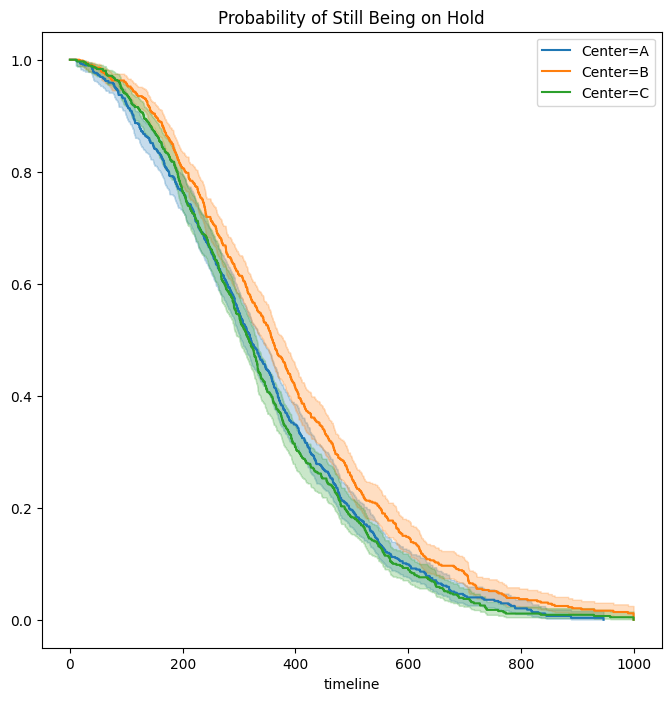

In [25]:
fig, ax = subplots(figsize=(8,8))
by_center = {}
for center, df in D.groupby('Center'):
    by_center[center] = df
    km = KaplanMeierFitter()
    km_center = km.fit(df['Wait time'], df['Failed'])
    km_center.plot(label='Center=%s' % center, ax=ax)
ax.set_title("Probability of Still Being on Hold")

Next, we stratify by Time.

Text(0.5, 1.0, 'Probability of Still Being on Hold')

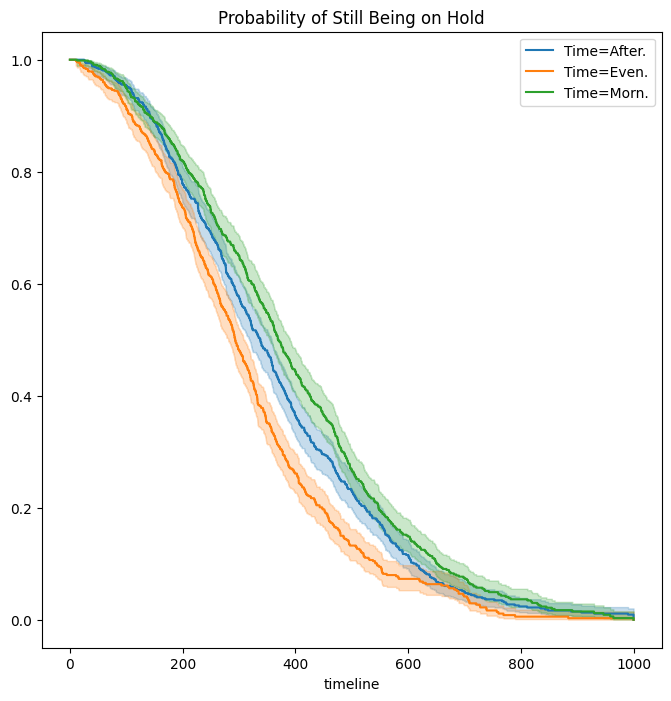

In [26]:
fig, ax = subplots(figsize=(8,8))
by_time = {}
for time, df in D.groupby('Time'):
    by_time[time] = df
    km = KaplanMeierFitter()
    km_time = km.fit(df['Wait time'], df['Failed'])
    km_time.plot(label='Time=%s' % time, ax=ax)
ax.set_title("Probability of Still Being on Hold")

It seems that calls at Call Center B take longer to be answered than calls at Centers A and C. Similarly, it appears that wait times are longest in the morning and shortest in the evening hours. We can use a log-rank test to determine whether these differences are statistically significant using the function ``multivariate_logrank_test()``.

In [27]:
multivariate_logrank_test(D['Wait time'],
                          D['Center'],
                          D['Failed'])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          20.30 <0.005     14.65

Next, we consider the effect of Time.

In [28]:
multivariate_logrank_test(D['Wait time'],
                          D['Time'],
                          D['Failed'])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          49.90 <0.005     35.99

As in the case of a categorical variable with 2 levels, these results are similar to the likelihood ratio test from the Cox proportional hazards model. First, we look at the results for ``Center``.

In [30]:
coxph = CoxPHFitter # shorthand
X = MS(['Wait time',
        'Failed',
        'Center'],
        intercept=False).fit_transform(D)
F = coxph().fit(X, 'Wait time', 'Failed')
F.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          20.58 <0.005     14.85

Next, we look at the results for ``Time``.

In [33]:
coxph = CoxPHFitter # shorthand
X = MS(['Wait time',
        'Failed',
        'Time'],
       intercept=False).fit_transform(D)
F = coxph().fit(X, 'Wait time', 'Failed')
F.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 2
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          48.12 <0.005     34.71

We find that differences between centers are highly significant, as are differences between times of day.

Finally, we fit Cox’s proportional hazards model to the data.

In [34]:
X = MS(D.columns,
       intercept=False).fit_transform(D)
fit_queuing = coxph().fit(
                  X,
                 'Wait time',
                 'Failed')
fit_queuing.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
Operators,0.043934,0.007520,5.143589e-09
Center[B],-0.236060,0.058113,4.864162e-05
Center[C],0.012231,0.057518,8.316096e-01
Time[Even.],0.268845,0.057797,3.294956e-06
Time[Morn.],-0.148217,0.057334,9.733557e-03


The $p$-values for Center B and evening time are very small. It is also clear that the hazard — that is, the instantaneous risk that a call will be answered — increases with the number of operators. Since we generated the data ourselves, we know that the true coefficients for ``Operators``, ``Center = B``, ``Center = C``, ``Time = Even.`` and ``Time = Morn.`` are $0.04$, $-0.3$, $0$, $0.2,$ and $-0.2$, respectively. The coefficient estimates from the fitted Cox model are fairly accurate.